## Installing and loading the Dataset

In [1]:
!pip3 install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 12.1 MB/s eta 0:00:00


In [2]:
!pip install keras

In [3]:
from datasets import load_dataset

dataset = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

## Installing necessary packages and libraries

In [4]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from gensim.models import Word2Vec
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

## Create 3 different Dataframe for further Analysis

In [5]:
df = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_valid =pd.DataFrame(dataset['validation'])

In [6]:
df.head()

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."


## Flatteing 3 different Dataframe

In [7]:
#For df_Train
df['Tokens'] = df['tokens'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
df['NER'] = df['ner_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

tokens = [token for sublist in df['Tokens'] for token in sublist]
ner_tags = [tag for sublist in df['NER'] for tag in sublist]

flat_df = pd.DataFrame({'Token': tokens, 'Ner_Tag': ner_tags})

In [8]:
flat_df.head()

,Token,Ner_Tag
0,For,B-O
1,this,B-O
2,purpose,B-O
3,the,B-O
4,Gothenburg,B-LF


In [9]:
#For df_test
df_test['Tokens'] = df_test['tokens'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
df_test['NER'] = df_test['ner_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

tokens_test = [token for sublist in df_test['Tokens'] for token in sublist]
ner_tags_test = [tag for sublist in df_test['NER'] for tag in sublist]

flat_df_test= pd.DataFrame({'Token': tokens_test, 'Ner_Tag': ner_tags_test})

In [10]:
#For df_valid
df_valid['Tokens'] = df_valid['tokens'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
df_valid['NER'] = df_valid['ner_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

tokens_valid = [token for sublist in df_valid['Tokens'] for token in sublist]
ner_tags_valid = [tag for sublist in df_valid['NER'] for tag in sublist]

flat_df_valid= pd.DataFrame({'Token': tokens_valid, 'Ner_Tag': ner_tags_valid})

## System 1 No preprocessing , Tfidf Vectorization , KNN

In [11]:
#creating copies to be used in this experiment
flat_df1=flat_df
flat_df1_test=flat_df_test
flat_df1_valid=flat_df_valid

flat_df1=flat_df
flat_df1_test=flat_df_test
flat_df1_valid=flat_df_valid

In [12]:
#creating a instance of calss Tfidfvectorizer
tfidf_vectorizer = TfidfVectorizer( )

In [13]:
#creating X_Train, X_Test,X_valid for model craetion
X =  flat_df1['Token']
y = flat_df1['Ner_Tag']
X_test = flat_df1_test['Token']
y_test = flat_df1_test['Ner_Tag']
X_valid = flat_df1_valid['Token']
y_valid = flat_df1_valid['Ner_Tag']

In [14]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_valid_tfidf=tfidf_vectorizer.transform(X_valid)

In [15]:
X_train_tfidf

<40000x7869 sparse matrix of type '<class 'numpy.float64'>'
	with 29329 stored elements in Compressed Sparse Row format>

In [16]:
X_test_tfidf

<5000x7869 sparse matrix of type '<class 'numpy.float64'>'
	with 3011 stored elements in Compressed Sparse Row format>

In [17]:
X_valid_tfidf

<5000x7869 sparse matrix of type '<class 'numpy.float64'>'
	with 2995 stored elements in Compressed Sparse Row format>

In [18]:
print(X_train_tfidf[:10])

  (0, 2931)	1.0
  (1, 7229)	1.0
  (2, 5920)	1.0
  (3, 7206)	1.0
  (4, 3181)	1.0
  (5, 7810)	1.0
  (6, 5430)	1.0
  (7, 2490)	1.0
  (8, 6451)	1.0


In [19]:
print(y[:10])

0     B-O
1     B-O
2     B-O
3     B-O
4    B-LF
5    I-LF
6    I-LF
7    I-LF
8    I-LF
9     B-O
Name: Ner_Tag, dtype: object


In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=25)

In [21]:
knn_classifier.fit(X_train_tfidf, y)

KNeighborsClassifier(n_neighbors=25)

In [22]:
y_pred = knn_classifier.predict(X_test_tfidf)


report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

        B-AC       1.00      0.01      0.03       270
        B-LF       0.25      0.03      0.05       150
         B-O       0.86      0.99      0.92      4292
        I-LF       0.38      0.05      0.08       288

    accuracy                           0.86      5000
   macro avg       0.62      0.27      0.27      5000
weighted avg       0.82      0.86      0.80      5000



In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

Accuracy: 0.8568
Precision: 0.6235653885492733
Recall: 0.2699659034034034
F1 Score: 0.2702655583690421
Hamming Loss: 0.1432


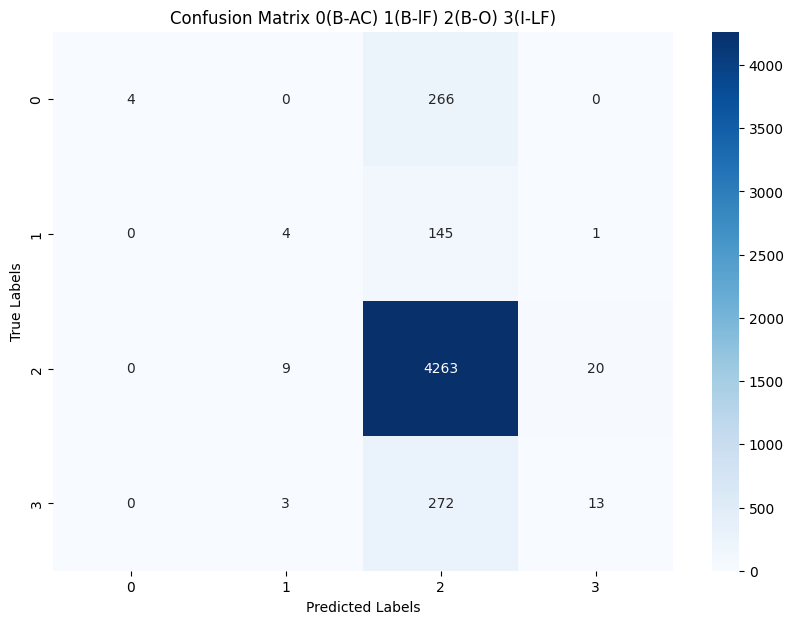

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix 0(B-AC) 1(B-lF) 2(B-O) 3(I-LF)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
df_predicted_KNN= pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'y_pred': y_pred
})

In [26]:
df_predicted_KNN.head()

,X_test,y_test,y_pred
0,Abbreviations,B-O,B-O
1,:,B-O,B-O
2,GEMS,B-AC,B-O
3,",",B-O,B-O
4,Global,B-LF,B-O


## **System 2 No preprocessing , fasttext Vectorization , KNN**

In [27]:
flat_df1.head()

,Token,Ner_Tag
0,For,B-O
1,this,B-O
2,purpose,B-O
3,the,B-O
4,Gothenburg,B-LF


In [28]:
# Encode the ner_tags
label_encoder = LabelEncoder()
flat_df1['Encoded_Tag'] = label_encoder.fit_transform(flat_df1['Ner_Tag'])
flat_df1_test['Encoded_Tag'] = label_encoder.transform(flat_df1_test['Ner_Tag'])

In [29]:
from gensim.models import FastText


tokens = [row.split() for row in flat_df1['Token']]  # Assuming each token is separated by a space

# FastText model
Fasttext_model= FastText(tokens, vector_size=100, window=5, min_count=1, workers=4)


In [30]:
import numpy as np

def vectorize(token, model):
    return model.wv[token] if token in model.wv else np.zeros(model.vector_size)


X = np.array([vectorize(token, Fasttext_model) for token in flat_df1['Token']])
X_test =np.array([vectorize(token, Fasttext_model) for token in flat_df1_test['Token']])

In [31]:
print(X)

[[ 1.04379340e-03 -1.88685150e-03 -1.92178669e-03 ...  1.18104217e-03
  -3.36294505e-03  2.44610314e-03]
 [ 1.14076433e-03  3.34119657e-03 -1.33493869e-03 ... -2.37689601e-05
   3.40386271e-03 -1.15793686e-04]
 [ 3.21004121e-03  8.01503717e-04 -3.43976752e-03 ...  2.50496785e-03
  -1.58503361e-03 -1.72686053e-03]
 ...
 [-3.34261102e-04  4.70247032e-04  6.65784115e-04 ... -8.79905419e-04
   3.83111270e-04  1.59678119e-03]
 [-8.05429241e-04  9.27802525e-04 -2.65061011e-04 ...  7.88405712e-04
   3.02777207e-03  2.59733293e-03]
 [-3.35044321e-03  3.15338722e-03  5.54983877e-03 ... -6.92472607e-03
  -5.12847537e-03 -1.01963058e-03]]


In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X, flat_df1['Encoded_Tag'])

KNeighborsClassifier(n_neighbors=25)

In [33]:
y_pred = knn.predict(X_test)

In [34]:
y_pred

array([2, 2, 2, ..., 2, 2, 2])

In [35]:
y_test =flat_df1_test['Encoded_Tag']

In [36]:
y_test

0       2
1       2
2       0
3       2
4       1
       ..
4995    3
4996    3
4997    3
4998    2
4999    0
Name: Encoded_Tag, Length: 5000, dtype: int64

In [37]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        B-AC       0.67      0.01      0.03       270
        B-LF       0.36      0.05      0.09       150
         B-O       0.87      0.99      0.92      4292
        I-LF       0.51      0.11      0.19       288

    accuracy                           0.86      5000
   macro avg       0.60      0.29      0.31      5000
weighted avg       0.82      0.86      0.81      5000



In [38]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

Accuracy: 0.8594
Precision: 0.601128139573218
Recall: 0.29335295424735075
F1 Score: 0.308356477796528
Hamming Loss: 0.1406


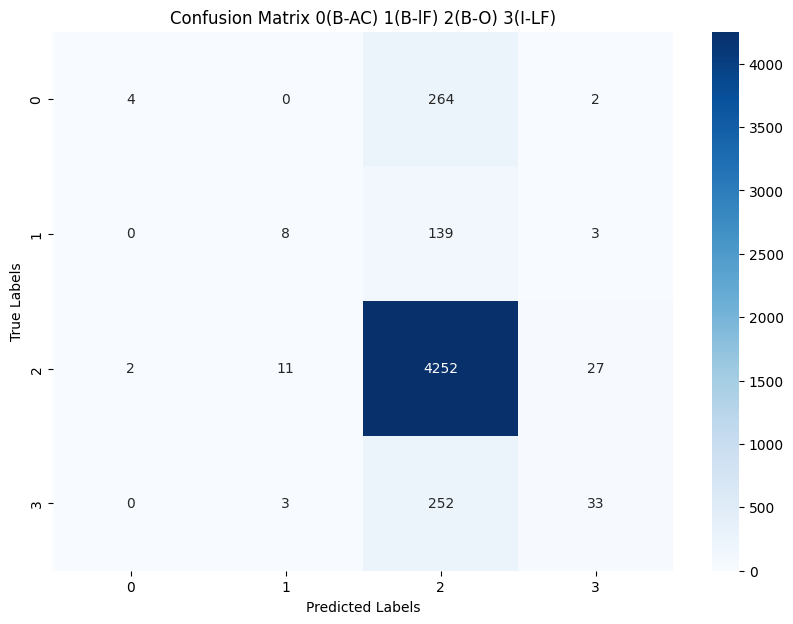

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix 0(B-AC) 1(B-lF) 2(B-O) 3(I-LF)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()